In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '/content/drive/MyDrive/ProjectDataSet'
width=256
height=256
depth=3

In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
import os

image_list, label_list = [], []

try:

    root_dir = os.listdir(directory_root)
    if ".DS_Store" in root_dir:
        root_dir.remove(".DS_Store")

    for plant_folder in root_dir:
        plant_path = os.path.join(directory_root, plant_folder)
        print("cCurrent folder ",plant_path)
        if os.path.isdir(plant_path):
            disease_folders = os.listdir(plant_path)
            if ".DS_Store" in disease_folders:
                disease_folders.remove(".DS_Store")

            for disease_folder in disease_folders:

                disease_path = os.path.join(plant_path, disease_folder)


                # image_path = os.path.join(disease_path, image)
                # print(image_path)
                if disease_path.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                    image_list.append(convert_image_to_array(disease_path))
                    label_list.append(plant_folder)


    print("[INFO] Image loading completed")

    # Now, we should have both image_list and label_list populated
    print("Total Images:", len(image_list))
    print("Total Labels:", len(label_list))

    # Proceed to label binarization if label_list is not empty
    if label_list:
        label_binarizer = LabelBinarizer()
        image_labels = label_binarizer.fit_transform(label_list)
        pickle.dump(label_binarizer, open('label_transform.pkl', 'wb'))
        n_classes = len(label_binarizer.classes_)
        print("Label binarization completed.")
    else:
        print("Error: label_list is empty. Make sure labels are properly loaded.")

except Exception as e:
    print(f"Error : {e}")


cCurrent folder  /content/drive/MyDrive/ProjectDataSet/Tomato_Leaf_Mold
cCurrent folder  /content/drive/MyDrive/ProjectDataSet/Tomato_Spider_mites_Two_spotted_spider_mite
cCurrent folder  /content/drive/MyDrive/ProjectDataSet/Tomato_Bacterial_spot
cCurrent folder  /content/drive/MyDrive/ProjectDataSet/Tomato_YellowLeaf
cCurrent folder  /content/drive/MyDrive/ProjectDataSet/Tomato_Early_blight
cCurrent folder  /content/drive/MyDrive/ProjectDataSet/Tomato_Late_blight
cCurrent folder  /content/drive/MyDrive/ProjectDataSet/Tomato_MosiacVirus
cCurrent folder  /content/drive/MyDrive/ProjectDataSet/Tomato_TargetSpot
cCurrent folder  /content/drive/MyDrive/ProjectDataSet/Tomato_Healthy
cCurrent folder  /content/drive/MyDrive/ProjectDataSet/Tomato_Septoria_leaf_spot
cCurrent folder  /content/drive/MyDrive/ProjectDataSet/Potato___Early_blight
cCurrent folder  /content/drive/MyDrive/ProjectDataSet/Pepper__bell___Bacterial_spot
cCurrent folder  /content/drive/MyDrive/ProjectDataSet/Potato___health

In [ ]:
from sklearn.preprocessing import LabelBinarizer
import pickle

# Assuming label_list is properly populated

if label_list:  # Check if label_list is not empty
    try:
        label_binarizer = LabelBinarizer()
        image_labels = label_binarizer.fit_transform(label_list)
        pickle.dump(label_binarizer, open('label_transform.pkl', 'wb'))
        n_classes = len(label_binarizer.classes_)
        print("Label binarization completed.")
    except Exception as e:
        print(f"Error during label binarization: {e}")
else:
    print("Error: label_list is empty. Make sure labels are properly loaded.")


Label binarization completed.


In [ ]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)


In [ ]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2,
    zoom_range=0.2,horizontal_flip=True,
    fill_mode="nearest")


In [ ]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (Batch  (None, 256, 256, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 85, 85, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        1

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_scheduler(epoch, lr):
    return lr * 0.9  # Adjust the decay factor as needed

opt = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1,
    callbacks=[lr_scheduler_callback]
)

print("[INFO] training network...")


Epoch 1/25
26/26 [==============================] - 28s 618ms/step - loss: 0.7933 - accuracy: 0.2582 - val_loss: 0.5862 - val_accuracy: 0.0748 - lr: 9.0000e-04
Epoch 2/25
26/26 [==============================] - 14s 554ms/step - loss: 0.5905 - accuracy: 0.3496 - val_loss: 1.0053 - val_accuracy: 0.1215 - lr: 8.1000e-04
Epoch 3/25
26/26 [==============================] - 14s 547ms/step - loss: 0.4182 - accuracy: 0.4300 - val_loss: 0.9978 - val_accuracy: 0.1121 - lr: 7.2900e-04
Epoch 4/25
26/26 [==============================] - 14s 533ms/step - loss: 0.2738 - accuracy: 0.4738 - val_loss: 1.2304 - val_accuracy: 0.1121 - lr: 6.5610e-04
Epoch 5/25
26/26 [==============================] - 14s 541ms/step - loss: 0.1954 - accuracy: 0.5786 - val_loss: 0.6526 - val_accuracy: 0.1215 - lr: 5.9049e-04
Epoch 6/25
26/26 [==============================] - 14s 532ms/step - loss: 0.1540 - accuracy: 0.6638 - val_loss: 0.5429 - val_accuracy: 0.0421 - lr: 5.3144e-04
Epoch 7/25
26/26 [======================

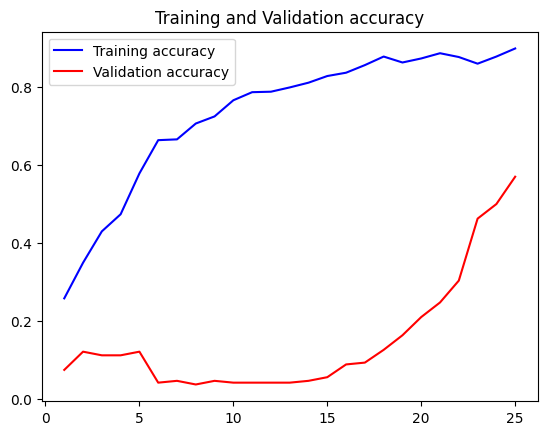

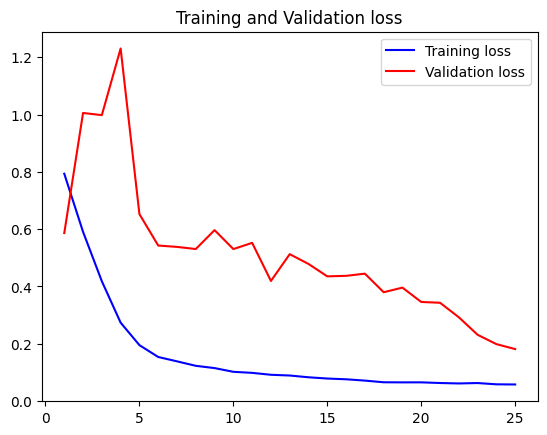

In [ ]:
acc = history.history['accuracy']  # 'accuracy' instead of 'acc'
val_acc = history.history['val_accuracy']  # 'val_accuracy' instead of 'val_acc'
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accuracy')  # 'Training accuracy' instead of 'accurarcy'
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')  # 'Validation accuracy' instead of 'accurarcy'
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()


In [ ]:

print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")


[INFO] Calculating model accuracy
7/7 [==============================] - 0s 30ms/step - loss: 0.1816 - accuracy: 0.5701
Test Accuracy: 57.009345293045044


In [ ]:
import tensorflow as tf

# Assuming you have a model named 'model'

# Save the model
tf.keras.models.save_model(model, 'plant.hdf5')


<ipython-input-16-c74541ac5319>:6: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model, 'plant.hdf5')
